In [2]:
!pip install xgboost lightgbm shap lime scikit-learn imbalanced-learn matplotlib pandas seaborn

In [3]:
# Install if needed
# !pip install xgboost lightgbm shap lime scikit-learn imbalanced-learn matplotlib pandas seaborn

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE


In [4]:
# load and quick preprocessing template


# Replace PATH and filename as needed
df = pd.read_csv("credit_data.csv")  # or pd.read_excel(...)
# Example: assume 'target' is the label
target_col = "target"

# Basic inspect
print(df.shape)
print(df[target_col].value_counts(normalize=True))

# Split features/target
X = df.drop(columns=[target_col])
y = df[target_col]

# Simple feature type split
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# Imputation and scaling for numeric; simple imputer for categorical (fillna 'missing')
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    # optionally encode - we'll let XGBoost handle label encoded categories or do one-hot if few categories
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], remainder="passthrough")

# Preprocess features (fit_transform on train later)
X_pre = preprocessor.fit_transform(X)
# store preprocessor
joblib.dump(preprocessor, "preprocessor.joblib")


(500, 8)
target
0    0.722
1    0.278
Name: proportion, dtype: float64


['preprocessor.joblib']

In [5]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, X.index, test_size=0.2, stratify=y, random_state=42
)

# Preprocess separately so we keep feature names for SHAP/LIME
preprocessor = preprocessor  # from above
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

# Option 1: use class_weight in XGBoost (scale_pos_weight)
# Option 2: SMOTE on training set (recommended to compare both)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_p, y_train)


In [6]:
xgb_clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", use_label_encoder=False, n_jobs=-1, random_state=42)

param_dist = {
    "n_estimators": [100, 200, 400],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 5, 10]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=40,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_bal, y_train_bal)
best = search.best_estimator_
joblib.dump(best, "xgb_best.joblib")
print("Best params:", search.best_params_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\ASUS\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:21:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [8]:
y_pred_proba = best.predict_proba(X_test_p)[:,1]
y_pred = (y_pred_proba >= 0.5).astype(int)  # choose threshold by business preference or optimize for F1/recall

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print("F1:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))



AUC: 0.5451388888888888
F1: 0.25925925925925924
              precision    recall  f1-score   support

           0       0.72      0.74      0.73        72
           1       0.27      0.25      0.26        28

    accuracy                           0.60       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.59      0.60      0.60       100

Confusion matrix:
 [[53 19]
 [21  7]]


        gain
f4  1.145954
f1  0.916361
f6  0.900027
f3  0.882841
f5  0.878956
f0  0.799327
f2  0.776618


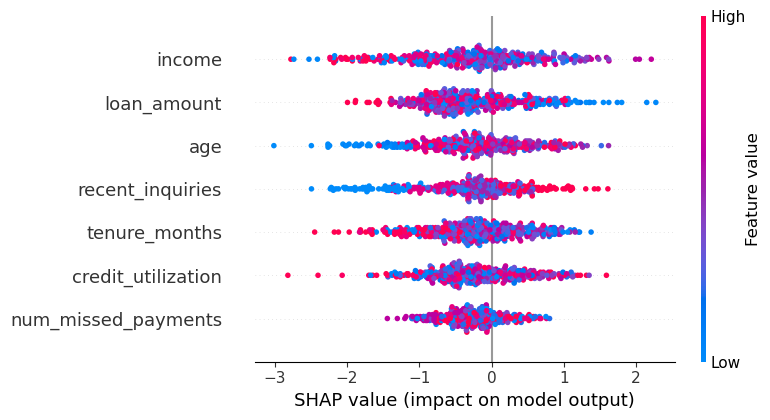

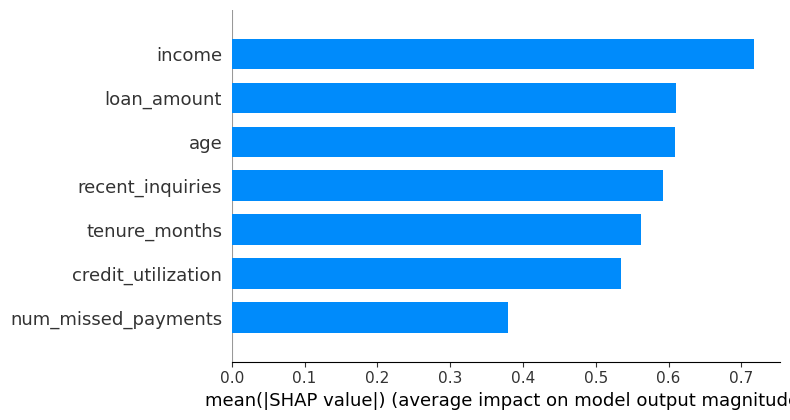

In [9]:
# Model gain importance (from XGBoost)
importance = best.get_booster().get_score(importance_type="gain")
imp_df = pd.DataFrame.from_dict(importance, orient="index", columns=["gain"]).sort_values("gain", ascending=False)
print(imp_df.head(20))

# SHAP global explanation
explainer = shap.Explainer(best)  # TreeExplainer for tree models
# Use a subset to speed up
sample_background = shap.sample(X_train_p, 100, random_state=42)
shap_values = explainer(sample_background)

# SHAP summary (beeswarm)
shap.summary_plot(explainer(X_train_p), X_train_p, feature_names=num_cols + cat_cols)
# SHAP bar plot (mean abs)
shap.summary_plot(explainer(X_train_p), X_train_p, feature_names=num_cols + cat_cols, plot_type="bar")


In [10]:
# compute probabilities on all original rows
X_all_p = preprocessor.transform(X)
probs_all = best.predict_proba(X_all_p)[:,1]
df_with_probs = df.copy()
df_with_probs["pred_proba"] = probs_all

# select top 5 highest predicted default probabilities (that are actually in test set is optional)
top5 = df_with_probs.sort_values("pred_proba", ascending=False).head(5)
top5_indices = top5.index.tolist()
print(top5[["pred_proba"] + num_cols + cat_cols].head())


     pred_proba  age  income  credit_utilization  num_missed_payments  \
167    0.995470   48   58102                0.31                    4   
87     0.994554   44   64425                0.26                    2   
449    0.987267   50   95745                0.63                    3   
306    0.985622   49   53307                0.21                    5   
9      0.984404   31   60158                0.09                    5   

     recent_inquiries  loan_amount  tenure_months  
167                 4       144153             21  
87                  4       189830             21  
449                 1       212779             96  
306                 3        56850             40  
9                   4       450457             45  


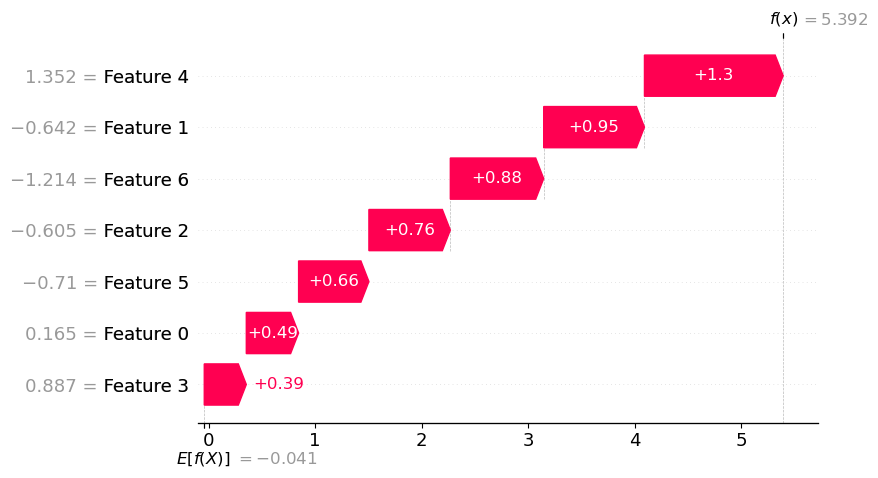

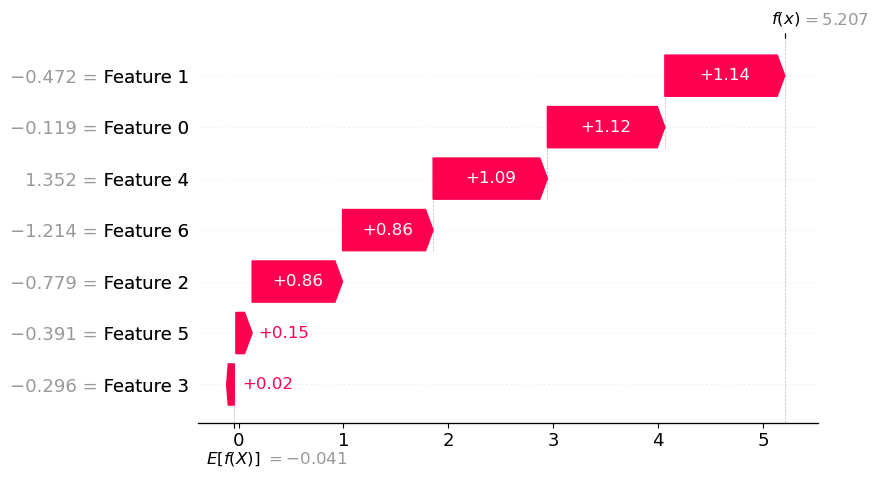

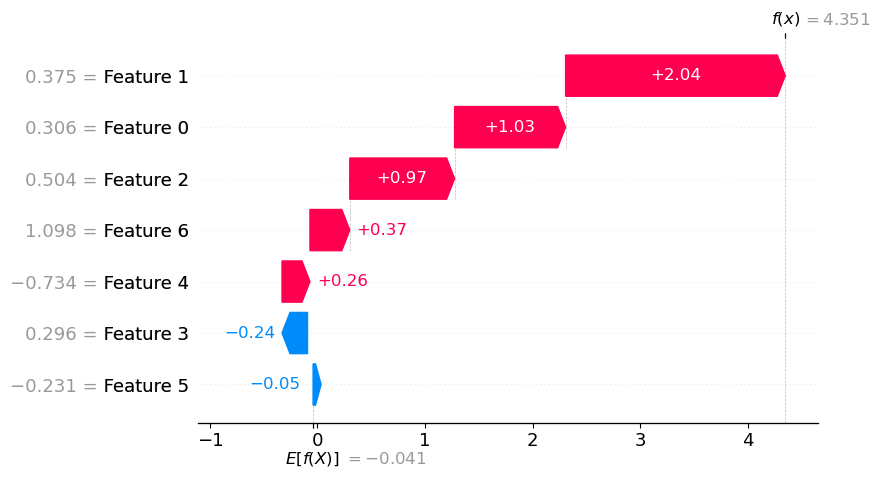

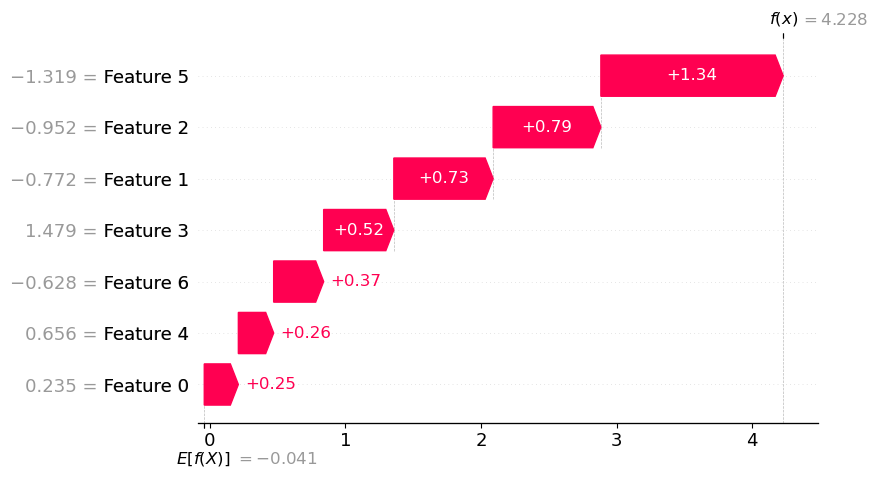

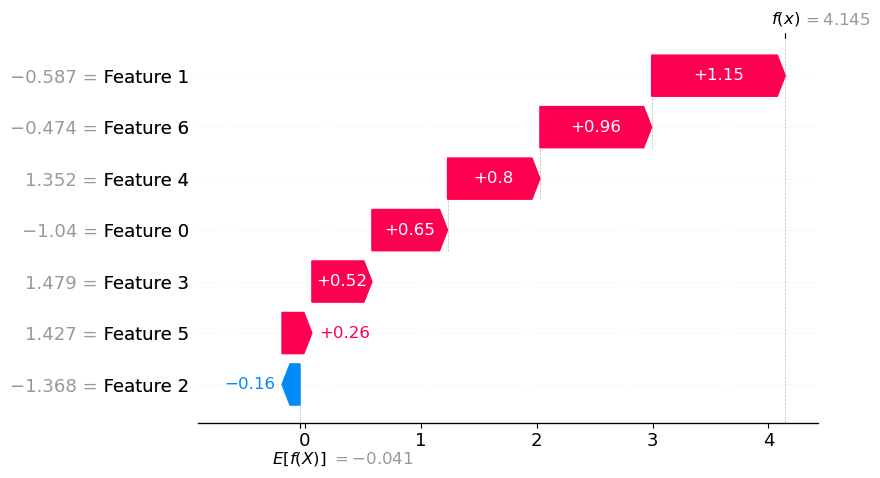

<Figure size 640x480 with 0 Axes>

In [11]:
# SHAP local: waterfall
for idx in top5_indices:
    x_raw = X.loc[idx:idx]  # dataframe
    x_processed = preprocessor.transform(x_raw)
    sv = explainer(x_processed)  # shape (1, n_features)
    # Waterfall
    shap.plots.waterfall(sv[0], max_display=12)   # shows positive/negative contributions
    plt.title(f"SHAP waterfall for index {idx}")
    plt.savefig(f"shap_waterfall_{idx}.png", bbox_inches="tight")
    plt.clf()

    # Numeric table
    shap_vals = sv.values[0]
    feature_names = num_cols + cat_cols
    local_df = pd.DataFrame({
        "feature": feature_names,
        "value": x_processed.flatten(),   # careful: if encoding changes shape, map back correctly
        "shap_value": shap_vals
    }).sort_values("shap_value", key=abs, ascending=False)
    local_df.to_csv(f"shap_local_{idx}.csv", index=False)

    # LIME
    # Build an explainer using training matrix and feature names
    lime_explainer = LimeTabularExplainer(
        training_data=np.array(X_train_p),
        feature_names=feature_names,
        class_names=["no_default", "default"],
        mode="classification"
    )
    exp = lime_explainer.explain_instance(
        data_row=x_processed.flatten(),
        predict_fn=lambda x: best.predict_proba(x)  # expects preprocessed input
    )
    # Save LIME explanation
    exp.save_to_file(f"lime_{idx}.html")
